In [1]:
from common import *
from experiment import *
from data import DirectRawData, RawData, PlottableData

# Find network settings based on theoretical data

We want to find network settings that fit our hypothesis of split TCP behavior for certain CCAs based on theoretical data from `parameter_exploration.ipynb`.

In [2]:
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr'),
    TCPTreatment(cca='bbr2', pep=False, label='tcp_bbr2'),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
    TCPTreatment(cca='cubic', pep=True),
    TCPTreatment(cca='bbr', pep=True, label='tcp_bbr'),
    TCPTreatment(cca='bbr2', pep=True, label='tcp_bbr2'),
    TCPTreatment(cca='bbr', pep=True, label='tcp_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
]
TCP_CUBIC = TREATMENTS[0]
TCP_BBRV3 = TREATMENTS[1]
TCP_BBRV2 = TREATMENTS[2]
TCP_BBRV1 = TREATMENTS[3]
PEP_CUBIC = TREATMENTS[4]
PEP_BBRV3 = TREATMENTS[5]
PEP_BBRV2 = TREATMENTS[6]
PEP_BBRV1 = TREATMENTS[7]

## Helper functions

In [3]:
losses = [0, 1, 2, 3, 4]
delays = [1, 20, 40, 60, 80, 100]
bws = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
treatments = [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3]
num_trials = 5

# Create experiment
exp = Experiment(
    num_trials, treatments, [], [],
    network_losses=[str(loss) for loss in losses],
    network_delays=delays,
    network_bws=bws,
    timeout=180,
    cartesian=False,
)
raw_data = DirectRawData(exp, execute=False)

# Get plottable data
metric = 'throughput_mbps'
data = PlottableData(raw_data, metric=metric)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 50 --delay1 100 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 62500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 60 --delay1 100 --loss1 0 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 75000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 60 --delay1 80 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 75000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 70 --delay1 80 --loss1 0 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 87500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 70 --delay1 60 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 87500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 80 --delay1 60 --loss1 0 --topology direct -t 4 --label tcp_cubic tcp -cca cubic -n 100000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 90 --delay1 40 --loss1 0 --t

In [4]:
# Functions that help determine which split network settings combine to make an e2e network setting
def combine_loss(loss_i, loss_j):
    return loss_i + loss_j

def combine_delay(delay_i, delay_j):
    combined_delay = 0
    combined_delay += 0 if delay_i == 1 else delay_i
    combined_delay += 0 if delay_j == 1 else delay_j
    return combined_delay

def combine_bw(bw_i, bw_j):
    return min(bw_i, bw_j)

def get_splits(sorted_values, combine_func):
    splits = set()
    max_value = sorted_values[-1]
    for value_i in sorted_values:
        for value_j in sorted_values:
            combined_value = combine_func(value_i, value_j)
            if combined_value <= max_value:
                splits.add((value_i, value_j))
    return list(sorted(list(splits)))

In [5]:
from enum import Enum

class SplitType(Enum):
    SIDEKICK = 1
    SIDEKICK_MIRROR = 2
    ZERO_LOSS = 3
    SYMMETRIC = 4
    SYMMETRIC_ALMOST = 5
    BOTH_LOSSY = 6
    OTHER = 7

# Predicted throughput results for a split network setting and its combined network setting
class ThroughputResult:
    def __init__(self, near_ns, far_ns, e2e_ns, bottleneck_bw):
        self.near_ns = near_ns
        self.far_ns = far_ns
        self.e2e_ns = e2e_ns
        self.bottleneck_bw = bottleneck_bw
        self.data = {}
    
    def add(self, treatment, near, far, e2e):
        self.data[treatment.label()] = {
            'near': near,
            'far': far,
            'split': min(near, far),
            'e2e': e2e,
        }

    def split_type(self) -> SplitType:
        bw = self.e2e_ns.get('bw1')
        delay1 = self.near_ns.get('delay1')
        delay2 = self.far_ns.get('delay1')
        loss1 = self.near_ns.get('loss1')
        loss2 = self.far_ns.get('loss1')
        if delay1 == 1 and loss1 > 0 and delay2 > 1 and loss2 == 0:
            return SplitType.SIDEKICK
        elif delay2 == 1 and loss2 > 0 and delay1 > 1 and loss1 == 0:
            return SplitType.SIDEKICK_MIRROR
        elif loss1 == 0 and loss2 == 0:
            return SplitType.ZERO_LOSS
        elif delay1 == delay2 and loss1 == loss2:
            return SplitType.SYMMETRIC
        elif abs(delay1 - delay2) <= 20 and abs(loss1 - loss2) <= 1:
            return SplitType.SYMMETRIC_ALMOST
        elif loss1 > 0 and loss2 > 0:
            return SplitType.BOTH_LOSSY
        else:
            return SplitType.OTHER

    def bw_exceeds(self, bw):
        return self.bottleneck_bw > bw

    def is_sidekick_split_type_mirror(self) -> bool:
        low_near_delay = self.far_ns.get('delay1') == 1
        high_far_delay = self.near_ns.get('delay1') > 1
        high_near_loss = self.far_ns.get('loss1') > 0
        low_far_loss = self.near_ns.get('loss1') == 0
        return low_near_delay and high_far_delay and high_near_loss and low_far_loss

    def has_split_improvement(self, treatment) -> bool:
        subdata = self.data[treatment.label()]
        return subdata['split'] > subdata['e2e']

    def split_improvement_exceeds(self, treatment, limit) -> bool:
        subdata = self.data[treatment.label()]
        split = subdata['split']
        e2e = subdata['e2e']
        if split <= e2e:
            return False           
        elif e2e == 0:
            return True
        else:
            return (split - e2e) / e2e > limit

    def is_high(self, treatment, pep: bool, limit=0.5) -> bool:
        subdata = self.data[treatment.label()]
        throughput = subdata['split'] if pep else subdata['e2e']
        return throughput >= limit * self.bottleneck_bw

    def is_low(self, treatment, pep: bool, limit=0.5) -> bool:
        subdata = self.data[treatment.label()]
        throughput = subdata['split'] if pep else subdata['e2e']
        return throughput < limit * self.bottleneck_bw
    
    def bbr1v3_improvement_exceeds(self, limit) -> bool:
        """The limit 1 means bbrv1 is 100% better (or 2x better) than v3.
        """
        bbr1 = self.data[TCP_BBRV1.label()]['e2e']
        bbr3 = self.data[TCP_BBRV3.label()]['e2e']
        if bbr1 <= bbr3:
            return False
        elif bbr3 == 0:
            return True
        else:
            return (bbr1 - bbr3) / bbr3 > limit

    def __repr__(self) -> str:
        delay1 = self.near_ns.get('delay1')
        delay2 = self.far_ns.get('delay1')
        delay_str = f'delay({delay1}, {delay2})={combine_delay(delay1, delay2)}'
        loss1 = self.near_ns.get('loss1')
        loss2 = self.far_ns.get('loss1')
        loss_str = f'loss({loss1}, {loss2})={combine_loss(loss1, loss2)}'
        bw1 = self.near_ns.get('bw1')
        bw2 = self.far_ns.get('bw1')
        bw_str = f'bw({bw1}, {bw2})={combine_bw(bw1, bw2)}'
        return f'{delay_str} {loss_str} {bw_str}'


def get_metric(pdp, default=None):
    return default if pdp is None else pdp.mean

def get_throughput_result(data, treatments, loss1, loss2, delay1, delay2, bw1, bw2):
    bw = combine_bw(bw1, bw2)
    data_size = int(10*1000000*bw/8)

    # Create network settings for each path segment and e2e segment
    near_ns = DirectNetworkSetting(loss=loss1, delay=delay1, bw=bw1)
    far_ns = DirectNetworkSetting(loss=loss2, delay=delay2, bw=bw2)
    e2e_ns = DirectNetworkSetting(loss=combine_loss(loss1, loss2), delay=combine_delay(delay1, delay2), bw=bw)

    # Get relevant predicted throughputs from the data
    result = ThroughputResult(near_ns, far_ns, e2e_ns, bw)
    for treatment in treatments:
        subdata = data.data[treatment.label()]
        try:
            near_pred = get_metric(subdata[near_ns.label()].get(data_size), default=0)
            far_pred = get_metric(subdata[far_ns.label()].get(data_size), default=0)
            e2e_pred = get_metric(subdata[e2e_ns.label()].get(data_size), default=0)
            result.add(treatment, near_pred, far_pred, e2e_pred)
        except:
            print(label)
            print(near_ns.label())
            print(far_ns.label())
            print(e2e_ns.label())
            raise Exception()
    return result

In [6]:
# Function that plots what the predicted data looks like
def plot_predicted_data(result: ThroughputResult, ylabel='Goodput (Mbit/s)'):
    # Data for the bars
    groups = [treatment for treatment in result.data.keys()]
    
    # Bar width and positions
    bar_width = 0.35
    x = np.arange(len(groups))  # group positions
    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Add bars for each treatment
    split_values = [result.data[treatment]['split'] for treatment in groups]
    ax.bar(x - bar_width/2, split_values, bar_width, label='split')
    e2e_values = [result.data[treatment]['e2e'] for treatment in groups]
    ax.bar(x + bar_width/2, e2e_values, bar_width, label='e2e')
        
    # Labeling and formatting
    ax.set_xlabel('Congestion Control Algorithms')
    ax.set_ylabel(ylabel)
    ax.set_title(result.split_type().name + ' ' + result.__repr__())
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## Filter desired network settings

In [7]:
# Function to get all plausible network setting combinations from the parameter exploration space
def get_initial_results(losses, delays, bws):
    loss_splits = get_splits(losses, combine_loss)
    delay_splits = get_splits(delays, combine_delay)
    # bw_splits = get_splits(bws, combine_bw)
    bw_splits = [(bw, bw) for bw in bws]
    
    results = []
    for bw1, bw2 in bw_splits:
        for loss1, loss2 in loss_splits:
            for delay1, delay2 in delay_splits:
                result = get_throughput_result(data, treatments, loss1, loss2, delay1, delay2, bw1, bw2)
                results.append(result)
    return results

In [14]:
def filter_by(results, func):
    results = list(filter(func, results))
    print(len(results))
    return results

# Get initial results
results = get_initial_results(losses, delays, bws)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_improvement_exceeds(TCP_CUBIC, 1))
results = filter_by(results, lambda x: x.split_improvement_exceeds(TCP_BBRV3, 1))
results = filter_by(results, lambda x: x.is_high(TCP_BBRV1, pep=False, limit=0.01))

# Filter by more result trend criteria
results = filter_by(results, lambda x: x.is_high(TCP_CUBIC, pep=False, limit=0.01))
# results = filter_by(results, lambda x: x.is_high(TCP_CUBIC, pep=True)) # PEPs help cubic and bbrv3
# results = filter_by(results, lambda x: x.is_high(TCP_BBRV1, pep=True))
# results = filter_by(results, lambda x: x.is_high(TCP_BBRV3, pep=True))
# results = filter_by(results, lambda x: x.is_low(TCP_CUBIC, pep=False))
# results = filter_by(results, lambda x: x.is_low(TCP_BBRV3, pep=False))
# results = filter_by(results, lambda x: x.bbr1v3_improvement_exceeds(0))
# results = filter_by(results, lambda x: x.is_high(TCP_BBRV1, pep=False))
# results = filter_by(results, lambda x: x.split_improvement_exceeds(TCP_BBRV3, 1))
# results = filter_by(results, lambda x: x.is_high(TCP_CUBIC, pep=False, limit=0.05))

# Filter by network type
results = filter_by(results, lambda x: x.split_type() == SplitType.SYMMETRIC)

# Print all results
for result in results:
    print(result)

3150
963
319
169
8
0


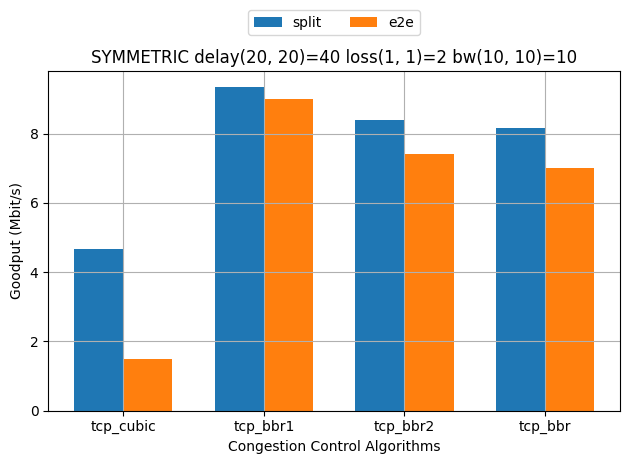

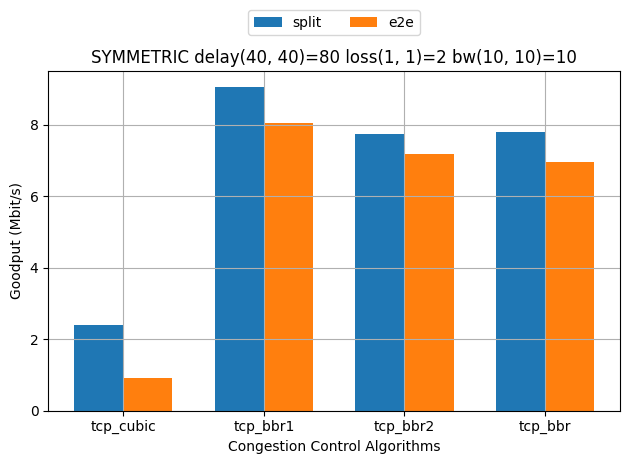

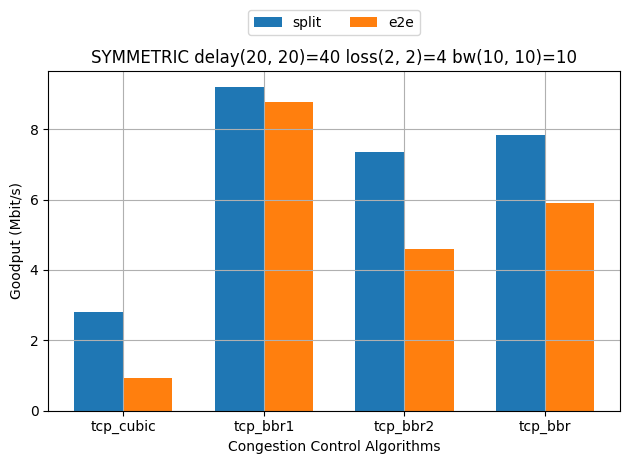

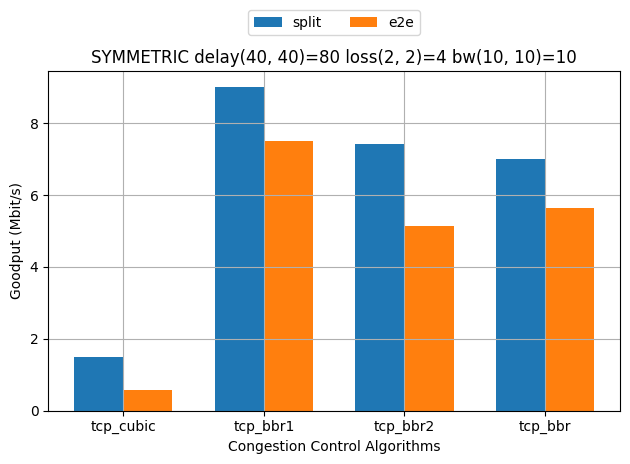

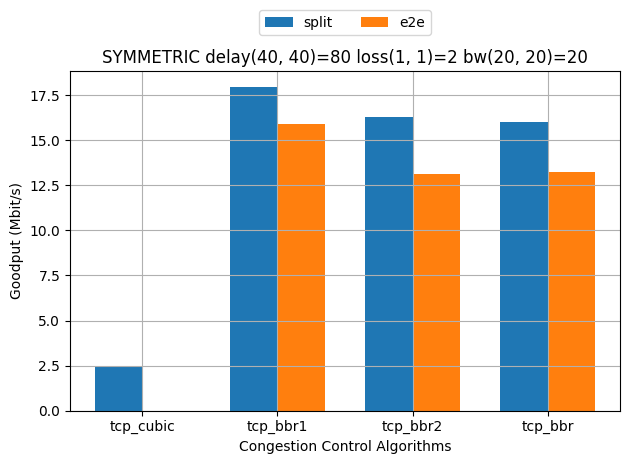

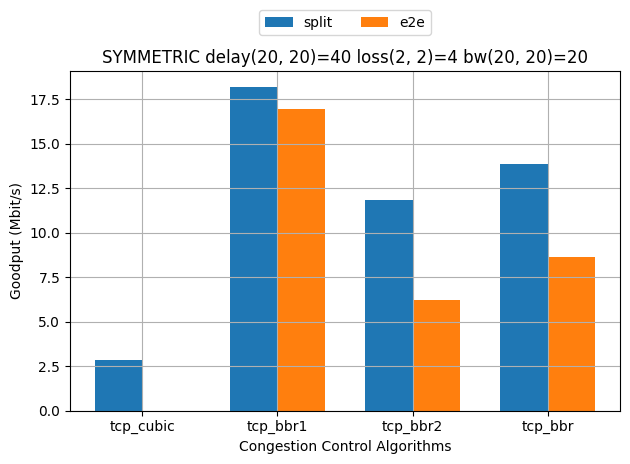

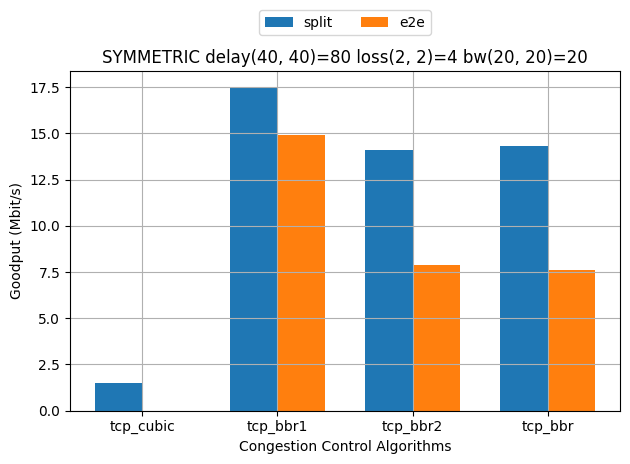

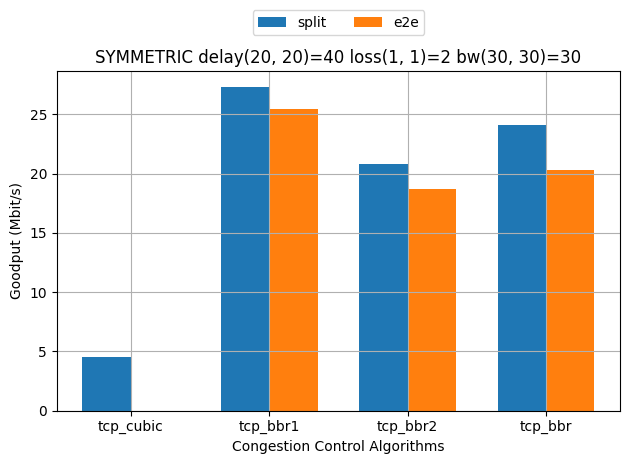

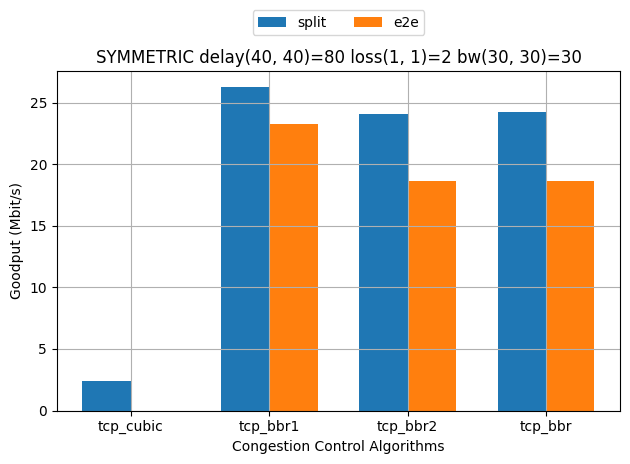

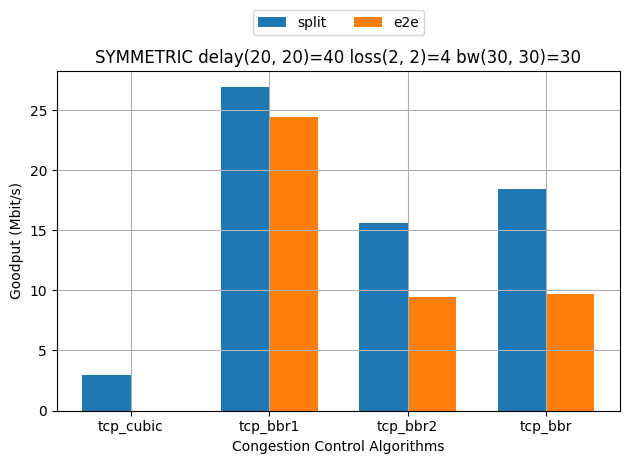

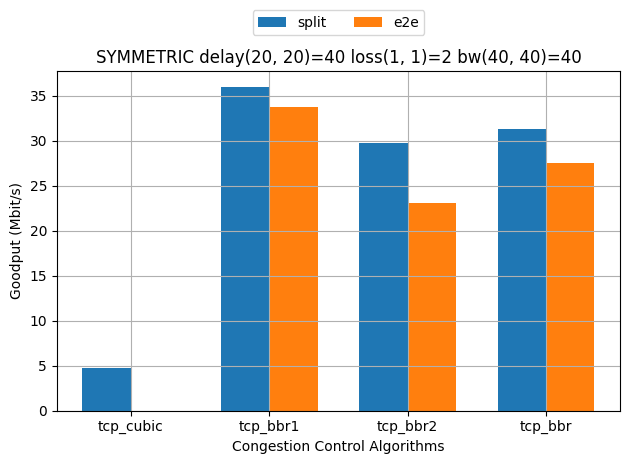

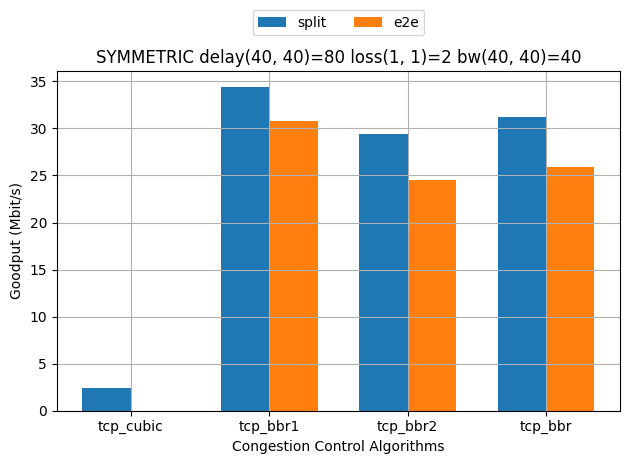

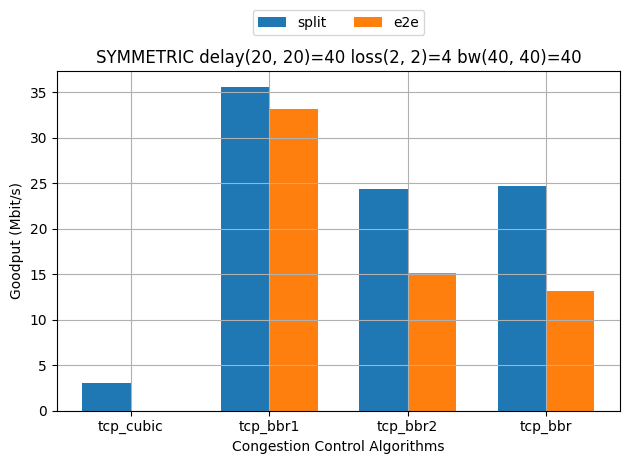

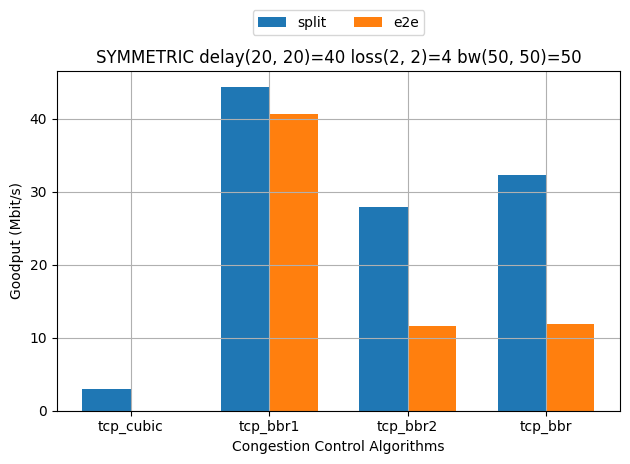

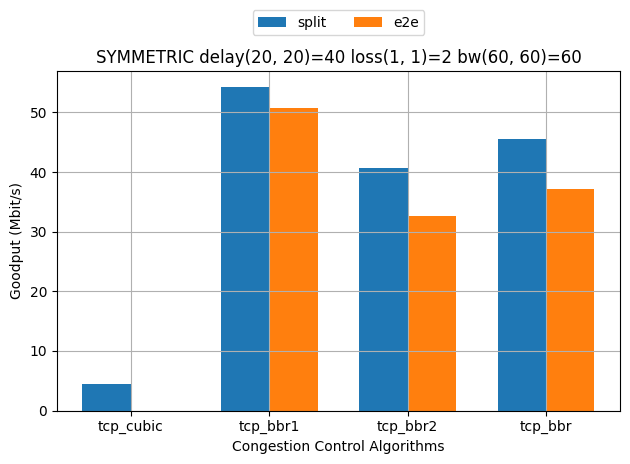

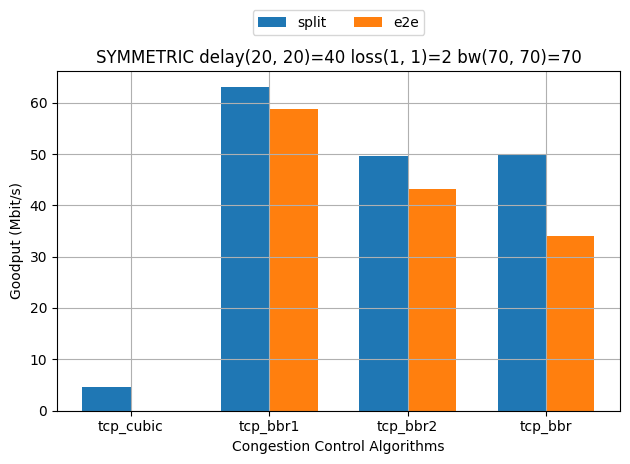

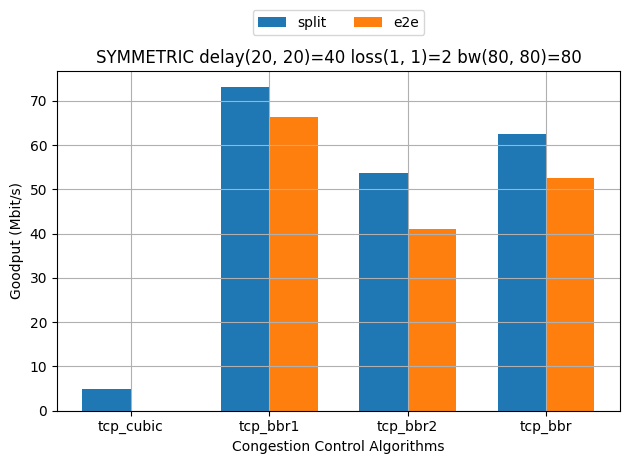

In [13]:
# Plot to help visualize the predicted results
for result in results:
    plot_predicted_data(result)

# Pick network settings and other configurations for real data

Note the network settings down here without needing to re-analyze theoretical data that may not be on this machine.

* We aim to test releases of BBRv1 dating back to 2016.
* In **TCPBenchmark**, the Python code keeps the `<cca>` as is and sets the Linux 
  congestion control module `sysctl -w net.ipv4.tcp_congestion_control=<cca>`.
* This notebook is only for plotting data. Execute the data on each Linux kernel
  and aggregate the data separately.

<!-- Not in use:
* In **QUICBenchmark**, the Python code converts the `<cca>` into an `<option>`
such as `TBBR-20240101`. The Chromium QUIC code receives this option via
`--client_connection_options=<option>` and `--connection_options=<option>`.
_We should pre-compile congestion control files linked to these options
in the Chromium QUIC code._
* These may be challenging, depending on how consistent the interfaces
between Linux kernel congestion control modules and TCP, and
Chromium QUIC congestion control modules and the newest toy client
and server, are over time.
* In the TCP benchmark, we can add another layer in the Python code from the
date to the actual module, similar to what exists in the QUIC benchmark. -->

In [15]:
# Generate the treatments
treatments_map = {
    'tcp': [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3],
    'pep': [PEP_CUBIC, PEP_BBRV1, PEP_BBRV2, PEP_BBRV3],
}

In [17]:
# Generate a representative network setting and data size
num_trials = 1
network_settings = [
    NetworkSetting(delay1=1, delay2=20, loss1='4', loss2='0', bw1=30, bw2=30),
    NetworkSetting(delay1=1, delay2=20, loss1='4', loss2='0', bw1=30, bw2=30).mirror(),
    NetworkSetting(delay1=20, delay2=20, loss1='2', loss2='2', bw1=50, bw2=50),
    NetworkSetting(delay1=1, delay2=20, loss1='3', loss2='1', bw1=30, bw2=30),
]
data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
data_sizes = [data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]

# Execute experiment on a single machine

For a given index, execute the TCP and PEP experiment on this machine.
The script automatically writes the data to the correct subdirectory in `data/`.
To aggregate all the data, we can `rsync` each the `data/` directory from each server
with the `data/` directory on a central machine. Then execute the remainder of the
Jupyter notebook to plot the data together.

In [ ]:
# Define the experiment
index = 1
exp = Experiment(
    num_trials=num_trials,
    treatments=[treatments_map['tcp'][index], treatments_map['pep'][index]],
    network_settings=network_settings,
    data_sizes=data_sizes,
    cartesian=False,
)

# Parse data
execute = True
raw_data = RawData(exp, execute=execute)

8
13.106077671051025ulation/main.py --bw1 30 --bw2 30 --delay2 20 --loss1 4 -t 1 --label tcp_bbr1 tcp --pep -cca bbr -n 37500000 
sudo -E python3 emulation/main.py --bw1 30 --bw2 30 --delay1 20 --delay2 1 --loss1 0 --loss2 4 -t 1 --label tcp_bbr1 tcp --pep -cca bbr -n 37500000 

# Plotting functions

In [42]:
def plot_bbr_over_time(data, cca_labels, treatments_map, delta=40, ylabel='Goodput (Mbit/s)'):
    assert len(data.network_settings) == 1
    network = data.network_settings[0]
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    # Data for the bars
    groups = [group for _, group in cca_labels]
    
    # Bar width and positions
    bar_width = 0.35
    x = np.arange(len(groups))  # group positions
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Add bars for each treatment
    for i, (label, cca_treatments) in enumerate(treatments_map.items()):
        ys = []
        yerr_lower = []
        yerr_upper = []

        for cca_treatment in cca_treatments:
            sublabel = cca_treatment.label()
            subdata = data.data[sublabel][network].get(data_size)
            if subdata is None:
                ys.append(0)
                yerr_lower.append(0)
                yerr_upper.append(0)
                continue
            ys.append(subdata.p(50))
            yerr_lower.append(subdata.p(50) - subdata.p(50-delta))
            yerr_upper.append(subdata.p(50+delta) - subdata.p(50))
        
        tcp_bars = ax.bar(x - bar_width/2 + i * bar_width, ys, bar_width, yerr=(yerr_lower, yerr_upper), label=label)
        
    # Labeling and formatting
    ax.set_xlabel('Congestion Control Algorithms')
    ax.set_ylabel(ylabel)
    ax.set_title(network)
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


# Plot data

MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label tcp_cubic tcp -cca cubic -n 125000000
MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label tcp_bbr2 tcp -cca bbr2 -n 125000000
MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label tcp_bbr3 tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label pep_cubic tcp --pep -cca cubic -n 125000000
MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label pep_bbr2 tcp --pep -cca bbr2 -n 125000000
MISSING: sudo -E python3 emulation/main.py --delay2 50 -t 1 --label pep_bbr3 tcp --pep -cca bbr -n 125000000


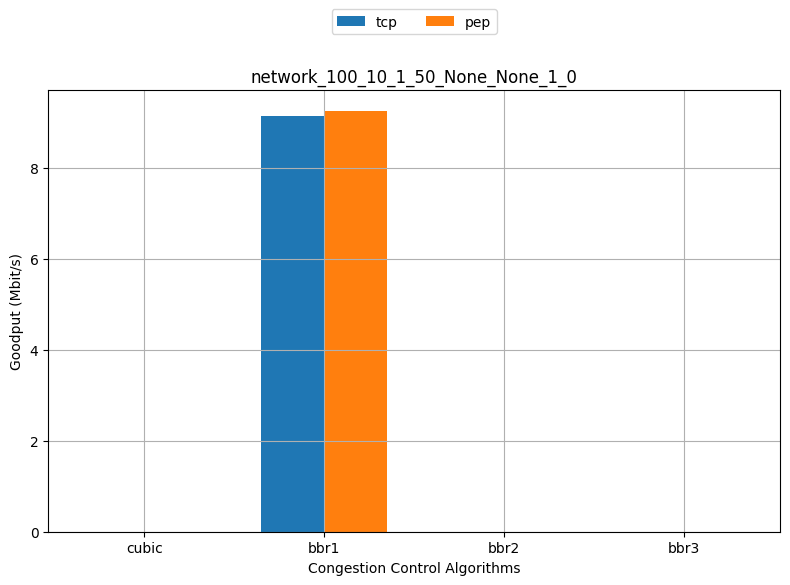

In [43]:
# Define the experiment
network_setting = network_settings[0]
exp = Experiment(
    num_trials=num_trials,
    treatments=sum(treatments_map.values(), []),
    network_settings=[network_setting],
    data_sizes=[data_size],
)

# Parse data
raw_data = RawData(exp, execute=False)

# Convert to plottable data
metric = 'throughput_mbps'
plottable_data = PlottableData(raw_data, metric=metric)
plot_bbr_over_time(plottable_data, cca_labels, treatments_map)